# Where should an alcoholic beverage company run promotions?

## 1. Background

### Project Goal
My company owns a chain of stores across Russia that sell a variety of alcoholic drinks. The company recently ran a wine promotion in Saint Petersburg that was very successful. Due to the cost to the business, it isn’t possible to run the promotion in all regions. The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

### Available Data
We have access to the per capita sales of wine, beer, spirits, vodka, champagne and brandy in regions of Russia between the years of 1998 and 2016.

### Business Questions

Before making any recommendations to the marketing team we will try to answer the following five questions:
1. How does alcohol consumption in St. Petersburn compare to that in other regions?
2. How do the sales of wine correlate to the sales of other alcoholic beverages?
3. Can we identify any regions that show similar alcohol consumption patterns to St. Petersburg over the last 5 years?
4. Can we identify any regions that show similar wine consumption patterns to St. Petersburg over the last 5 years?
5. Can we find correlations with the sales of other drinks in regions with a similar wine consumption as St. Petersburg?

## 2. Loading Data and Libraries

### 2.1 Importing libraries

In [231]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
!pip install kneed
from kneed import KneeLocator
from sklearn.metrics.pairwise import pairwise_distances

  Using cached kneed-0.8.1-py2.py3-none-any.whl (10 kB)
  Using cached scipy-1.9.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (33.8 MB)
  Using cached numpy-1.24.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.4.0 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.0 which is incompatible.
pythonwhat 2.23.1 requires asttokens~=1.1.10, but you have asttokens 2.0.8 which is incompatible.
pythonwhat 2.23.1 requires dill~=0.2.7.1, but you have dill 0.3.5.1 which is incompatible.
pythonwhat 2.23.1 requires jinja2~=2.10, but you have jinja2 3.1.2 which is incompatible.


In [232]:
# Function that creates a data quality report for a dataframe in python

def numerical_data_quality_report(df):
    # Calculate the number of rows and columns in the dataframe
    num_rows = df.shape[0]
    num_rows = df.shape[1]
    
    # Initialize empty dict to store results
    results = {}
    
    # Iterate through each column in the dataframe
    for col in df.columns:
        # Skip non numerical columns
        if df[col].dtype not in ['int', 'int64', 'float64']:
            continue
            
        # Calculate number of missing values
        num_missing = df[col].isnull().sum()
        
        # Calculate number of unique values
        num_unique = df[col].isunique()
        
        # Calculate summary statistics
        min_vale = df[col].min()
        max_value = df[col].max()
        mean_val = df[col].mean()
        median_val = df[col].median()
        
        # Calculate standard deviation and variance
        std_val = df[col].std()
        var_val = df[col].var()
        
        # Add the results to the dictionary
        results[col] = {
            'num_rows': num_rows,
            'num_cols': num_cols,
            'num_missing': num_missing,
            'num_unique': num_unique,
            'min_val': min_val,
            'max_val': max_val,
            'median_vale': median_val,
            'mean_val': mean_val,
            'std_val': std_val,
            'var_val': var_val
        }
        
        # Return results dictionary
        return results

### 2.2 Load Data

In [233]:
alcohol = pd.read_csv(r'./data/russian_alcohol_consumption.csv')
alcohol.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


In [234]:
alcohol.describe()

,year,wine,beer,vodka,champagne,brandy
count,1615.000000,1552.000000,1557.000000,1554.000000,1552.000000,1549.000000
mean,2007.000000,5.628144,51.260148,11.818694,1.313177,0.526998
std,5.478922,2.813208,25.372821,5.128806,0.797956,0.400201
min,1998.000000,0.100000,0.400000,0.050000,0.100000,0.000000
25%,2002.000000,3.575000,32.400000,8.300000,0.800000,0.200000
50%,2007.000000,5.400000,49.970000,11.500000,1.200000,0.400000
75%,2012.000000,7.377500,67.400000,15.000000,1.665000,0.700000
max,2016.000000,18.100000,207.300000,40.600000,5.560000,2.300000


### 2.2 Remove Missing Data

In [235]:
# Define segments
segments = ['wine', 'beer', 'vodka', 'champagne', 'brandy']
segments_shr = [s + '_shr' for s in segments]

# Check missing values
nan_count = alcohol[alcohol[segments].isnull().any(axis=1)]
nan_count['na_count'] = nan_count[segments].isnull().sum(axis=1)
nan_pivot = nan_count.pivot_table(index='region', columns='year', values='na_count', aggfunc='sum').fillna(0)
nan_pivot

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0
Republic of Crimea,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0
Republic of Ingushetia,5.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0
Sevastopol,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0


Since the 4 regions above have majority of their data missing we are going to drop these 4 regions entirely from the data.

In [236]:
# Drop regions with mostly missing data
print(alcohol.shape)
alcohol = alcohol[~alcohol.region.isin(nan_pivot.index.to_list())]
print(alcohol.shape)

(1615, 7)
(1539, 7)


In [237]:
print(alcohol.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1539 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1539 non-null   int64  
 1   region     1539 non-null   object 
 2   wine       1539 non-null   float64
 3   beer       1539 non-null   float64
 4   vodka      1539 non-null   float64
 5   champagne  1539 non-null   float64
 6   brandy     1539 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 96.2+ KB
None


We now see that none of our columns have null data after removing those 4 regions.

## 3. Business Questions

### 3.1 - How does alcohol consumption in St. Petersburn compare to that in other regions?

In [238]:
# Seperate data from only St. Petersburg
sp = alcohol[alcohol['region'] == 'Saint Petersburg']

# Get all regions besides St. Petersburg
not_sp = alcohol[alcohol['region'] != 'Saint Petersburg']

not_sp_avg = not_sp.groupby('year').mean()


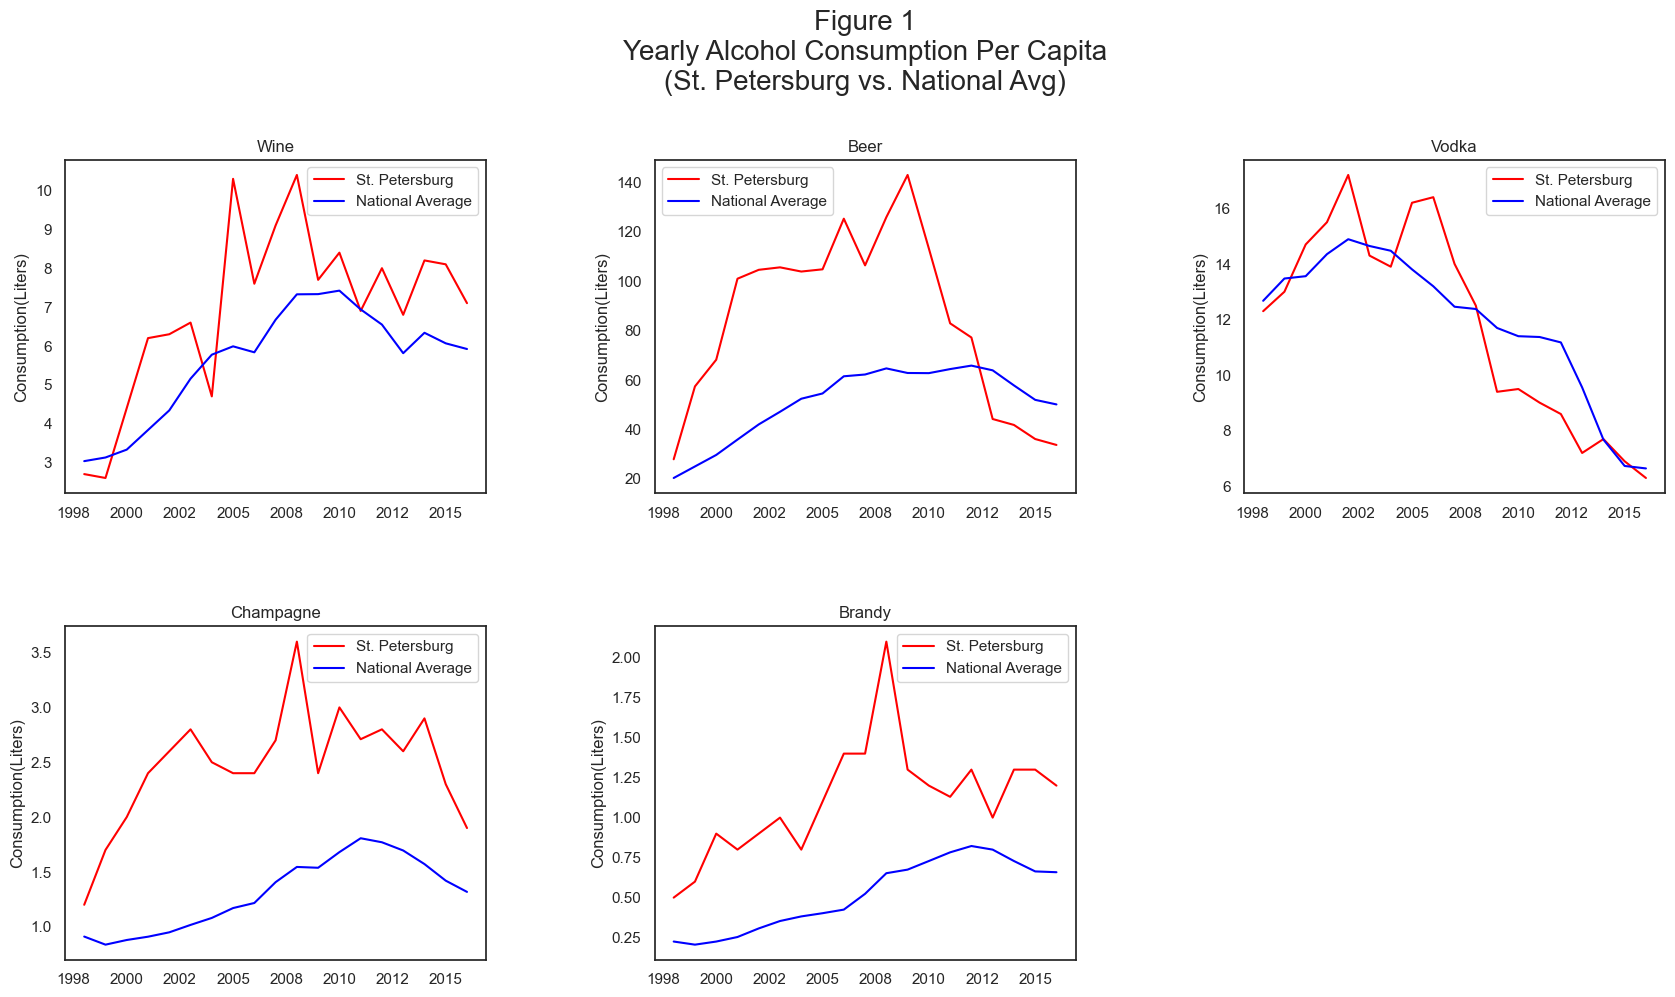

In [239]:
# Plotting alcohol sales per capita of St. Petersburg vs the Average of All other regions
%matplotlib inline

# Set style and context
sns.set_theme(context='notebook', style='white')

# Set figure and axes variables for subplots
fig, axes = plt.subplots(2, 3, figsize=(20,10))

# Hide unesed plot axes
axes[1,2].set_visible(False)

# Plot alcohol consumption for St. Petersburg
sns.lineplot(data=sp, x='year', y='wine', ax=axes[0, 0], color='red', label='St. Petersburg')
sns.lineplot(data=sp, x='year', y='beer', ax=axes[0, 1], color='red', label='St. Petersburg')
sns.lineplot(data=sp, x='year', y='vodka', ax=axes[0, 2], color='red', label='St. Petersburg')
sns.lineplot(data=sp, x='year', y='champagne', ax=axes[1, 0], color='red', label='St. Petersburg')
sns.lineplot(data=sp, x='year', y='brandy', ax=axes[1, 1], color='red', label='St. Petersburg')

# Plot average alcohol consumption for all other regions
sns.lineplot(data=not_sp_avg, x='year', y='wine', ax=axes[0, 0], color='blue', label='National Average')
sns.lineplot(data=not_sp_avg, x='year', y='beer', ax=axes[0, 1], color='blue', label='National Average')
sns.lineplot(data=not_sp_avg, x='year', y='vodka', ax=axes[0, 2], color='blue', label='National Average')
sns.lineplot(data=not_sp_avg, x='year', y='champagne', ax=axes[1, 0], color='blue', label='National Average')
sns.lineplot(data=not_sp_avg, x='year', y='brandy', ax=axes[1, 1], color='blue', label='National Average')

# Set labels for each subplot
axes[0,0].set(title='Wine', xlabel='', ylabel='Consumption(Liters)')
axes[0,1].set(title='Beer', xlabel='', ylabel='Consumption(Liters)')
axes[0,2].set(title='Vodka', xlabel='', ylabel='Consumption(Liters)')
axes[1,0].set(title='Champagne', xlabel='', ylabel='Consumption(Liters)')
axes[1,1].set(title='Brandy', xlabel='', ylabel='Consumption(Liters)')

#set format x-axis
from matplotlib.ticker import FormatStrFormatter
for c in axes:
   for ax in c:
      ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Set title for all subplots
fig.suptitle('Figure 1\nYearly Alcohol Consumption Per Capita\n(St. Petersburg vs. National Avg)', size= 20, y= 1.05)

# Set padding
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.show()

#### Observations
- St. Petersburg wine consumption is above the national average
- St. Petersburg beer consumption is below the national average
- St. Petersburg vodka consumption is close to the national average
- St. Petersburg champagne consumption is above the national average
- St. Petersburg brandy consumption is above the national average.

In general it appears that people in St. Petersburg consume on average more alcohol than the national average. Vodka and Beer consumption both nationally and locally in St. Petersburg have seen very large decline in consumption. All types of alcohol consumption have been declining since their peak in 2008. This [article](https://news.gallup.com/poll/353858/alcohol-consumption-low-end-recent-readings.aspx) outlines how Americans are consuming less alcohol. The article states that younger people(aged < 35) are as a whole consuming less alcohol. While the population from this article is not from the same region, it is possible that the population of Russia has seen a decline in consumption due to the reasons outlined in the article.

The population of St. Petersburg can be describe as consuming higher amounts of wine, brandy and champagne, and lower amounts of beer and vodka.

### 3.2 - How do the sales of wine correlate to the sales of other alcoholic beverages?

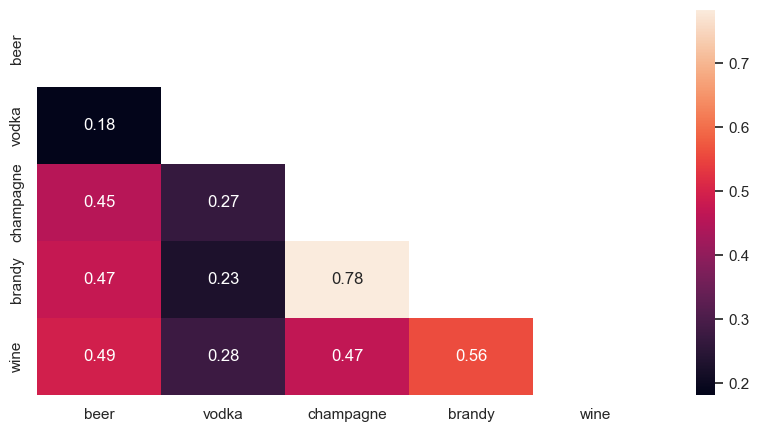

In [240]:
# Get correlation of wine consomuption to other veriables
corr = alcohol[['beer','vodka', 'champagne', 'brandy', 'wine']].corr(method='pearson')

# plot heatmap of correlations
fig, ax = plt.subplots(figsize=(10,5))

mask = np.triu(corr)
ax = sns.heatmap(corr, annot=True, mask=mask)

plt.show()

#### Observation
We used the Pearson method to find the correlation between each type of alcohol consumed. Values > 0.5 are considered to be strongly correlated. Values between 0.3-0.5 are considered to be moderately correlated and values < 0.3 are considered to be weakly correlated.

- Wine is most strongly correlated to brandy, with a correlation value of 0.56. This implies that those that consume a lot of wine are likely to also consume a lot of brandy.
- Wine consumption is moderately correlated to beer and champagne consumption having values of 0.49 and 0.47 respectively.
- Wine consumption is weakly correlated to consumption of vodka with a value of 0.28
- All types of alcohol consumption have at least a weak correlation in consumption to one another.


### 3.3 - Can we identify any regions that show similar alcohol consumption patterns to St. Petersburg over the last 5 years of data?
We are only going to include the most recent 5 year in our analysis. We are doing this because the sample of the last 5 years of data will represent the current trend of alcohol consumption. As shown in figure 1 above we can see that alcohol consumption has changed over time and we only want to capture what we consider to be the current trend.

#### Clustering Analysis
We are going to use clustering analysis, a type of unsupervised machine learning, to group data points into distinct categories based on their similarities. We will do this to help identify any patterns in the data that are not immediately apparent.

To perform clustering analysis we first must do the following:
- Deal with any missing data
- Determine optimal number of clusters
- Transform the data

Note that we already dealt with missing values and our dataset is complete so we will skip this step.

##### Determining optimal number of clusters
We are going to use the elbow method to find the optimal number of clusters for our data set.

In [241]:
# Subest the data for last 5 years
last5 = alcohol[alcohol['year'] > 2011]

# subest data by region with average consumption over last 5 years
last5_mean = last5.groupby('region').mean()
last5_mean = last5_mean.drop(columns=['year'])
last5_mean = last5_mean.reset_index()

last5_mean.columns = ['region', 'avg_wine', 'avg_beer', 'avg_vodka', 'avg_champagne', 'avg_brandy']

last5_mean.head()

,region,avg_wine,avg_beer,avg_vodka,avg_champagne,avg_brandy
0,Altai Krai,4.50,54.12,6.84,1.10,0.34
1,Altai Republic,4.48,48.78,8.42,1.08,0.38
2,Amur Oblast,6.16,62.50,8.90,1.68,0.58
3,Arkhangelsk Oblast,9.30,52.70,13.12,2.04,1.00
4,Astrakhan Oblast,4.64,59.48,6.36,0.98,0.64


In [242]:
# Standardize the data
scaler = StandardScaler()
last5_std = scaler.fit_transform(last5_mean[['avg_wine', 'avg_beer', 'avg_vodka', 'avg_champagne', 'avg_brandy']])

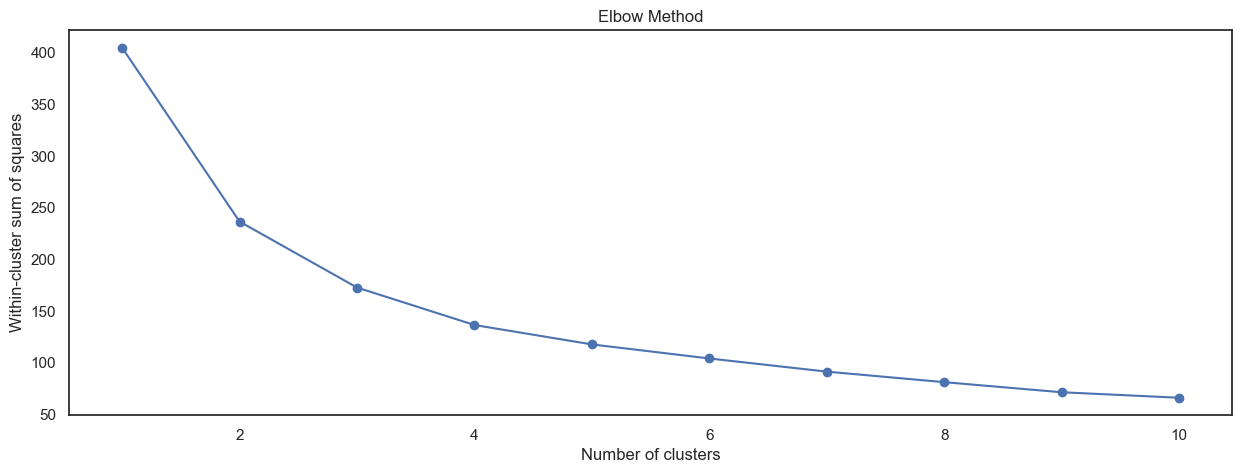

In [243]:
# Fit k-means model for a range of different values of k and calculate the WCSS for each value of K
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(last5_std)
    wcss.append(kmeans.inertia_)

# Plot the WCSS for each value of k
plt.figure(figsize=(15,5))
plt.plot(range(1, 11), wcss, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow Method')
plt.show()

In [244]:
kl = KneeLocator(range(1,11), wcss, curve='convex',direction='decreasing')

print(kl.elbow)

3


We will be using 3 clusters for our kmeans analysis.

In [245]:
# Perform kmeans with 2 clusters
kmeans = KMeans(n_clusters=3, random_state=5)
kmeans.fit(last5_std)

# assign data points to the clusters
clusters = kmeans.predict(last5_std)

#  add cluster assignments to the dataframe as new column
last5_mean['cluster'] = clusters + 1

# Group the dataframe by cluster value
last5_mean[last5_mean.region == 'Saint Petersburg'].head()

,region,avg_wine,avg_beer,avg_vodka,avg_champagne,avg_brandy,cluster
58,Saint Petersburg,7.64,46.6,7.34,2.5,1.22,3


We can see that Saint Petersburg belongs to the 2nd cluster. That means that it has similar alcohol consumption statistics to other regions in cluster 2.

In [246]:
related_regions = last5_mean[last5_mean['cluster'] == 3].copy()
related_regions['region']

3                        Arkhangelsk Oblast
8                 Chukotka Autonomous Okrug
14                       Kaliningrad Oblast
16                           Kamchatka Krai
19                          Khabarovsk Krai
20    Khanty–Mansi Autonomous Okrug – Yugra
22                            Komi Republic
28                         Leningrad Oblast
30                           Magadan Oblast
32                                   Moscow
33                            Moscow Oblast
34                          Murmansk Oblast
35                  Nenets Autonomous Okrug
37                          Novgorod Oblast
44                           Primorsky Krai
51                      Republic of Karelia
58                         Saint Petersburg
60                          Sakhalin Oblast
63                          Smolensk Oblast
65                        Sverdlovsk Oblast
71                            Tyumen Oblast
78           Yamalo-Nenets Autonomous Okrug
79                         Yaros

The above list represents all regions that our model found that have similar alcohol consumption trends to St. Petersburg.

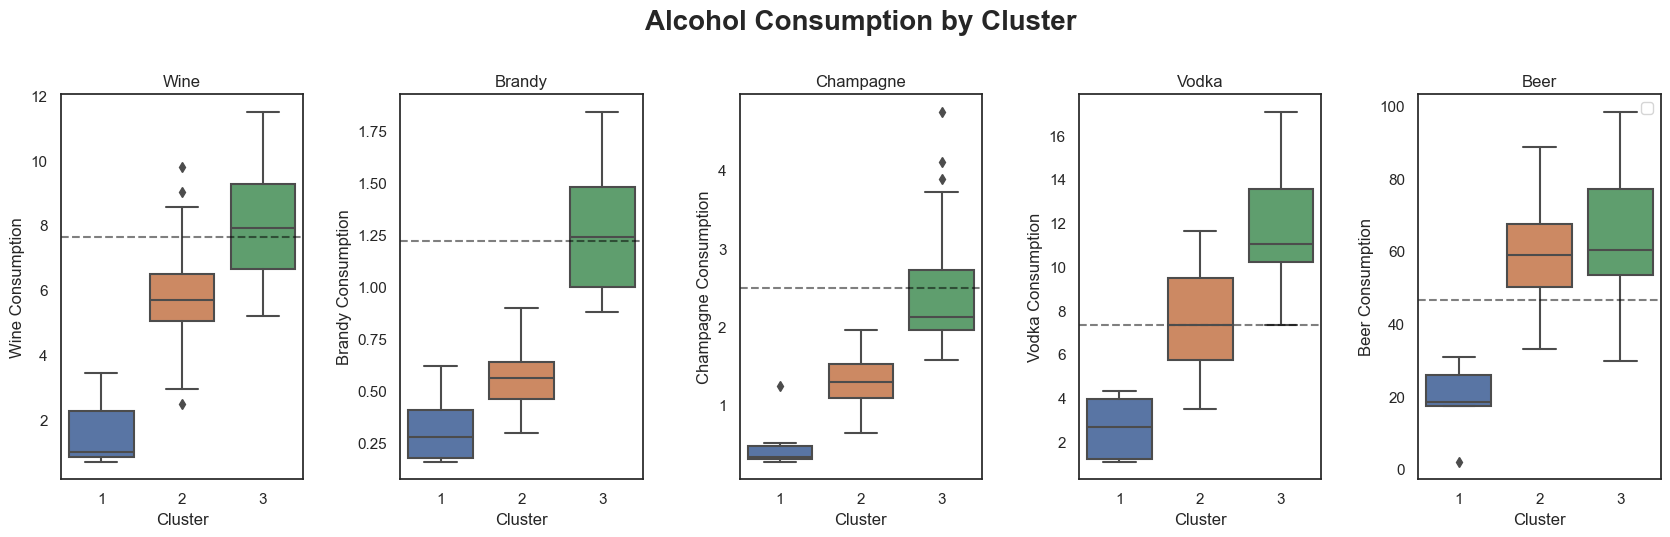

In [247]:
# get data for st. petersburg
avg_wine = last5_mean.loc[last5_mean.region == 'Saint Petersburg', 'avg_wine'].item()
avg_brandy = last5_mean.loc[last5_mean.region == 'Saint Petersburg', 'avg_brandy'].item()
avg_champagne = last5_mean.loc[last5_mean.region == 'Saint Petersburg', 'avg_champagne'].item()
avg_vodka = last5_mean.loc[last5_mean.region == 'Saint Petersburg', 'avg_vodka'].item()
avg_beer = last5_mean.loc[last5_mean.region == 'Saint Petersburg', 'avg_beer'].item()

# create subplot variables
fig, axes = plt.subplots(1,5, figsize=(20,5), sharex=True)

# Plot data
sns.boxplot(data=last5_mean, x='cluster', y='avg_wine', ax=axes[0])
sns.boxplot(data=last5_mean, x='cluster', y='avg_brandy', ax=axes[1])
sns.boxplot(data=last5_mean, x='cluster', y='avg_champagne', ax=axes[2])
sns.boxplot(data=last5_mean, x='cluster', y='avg_vodka', ax=axes[3])
sns.boxplot(data=last5_mean, x='cluster', y='avg_beer', ax=axes[4])

# Set labels
axes[0].set(title='Wine', xlabel='Cluster', ylabel='Wine Consumption')
axes[1].set(title='Brandy', xlabel='Cluster', ylabel='Brandy Consumption')
axes[2].set(title='Champagne', xlabel='Cluster', ylabel='Champagne Consumption')
axes[3].set(title='Vodka', xlabel='Cluster', ylabel='Vodka Consumption')
axes[4].set(title='Beer', xlabel='Cluster', ylabel='Beer Consumption')

# plot line for st. petersburg
axes[0].axhline(y=avg_wine, color='black', ls='--', alpha=0.5)
axes[1].axhline(y=avg_brandy, color='black', ls='--', alpha=0.5)
axes[2].axhline(y=avg_champagne, color='black', ls='--', alpha=0.5)
axes[3].axhline(y=avg_vodka, color='black', ls='--', alpha=0.5)
axes[4].axhline(y=avg_beer, color='black', ls='--', alpha=0.5)

#set title for entire plot
plt.suptitle('Alcohol Consumption by Cluster', weight='bold', y=1.05, size=20)

# set padding for subplots
plt.subplots_adjust(left=0.1,
                    right=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.legend()
plt.show()

##### Observations
- We could classify each cluster by their alcohol consumption levels. Cluster 1 consumes the least, cluster 2 a moderate amount and cluster 3 the most.
- St. Petersburg fits nicely in cluster 3 for Wine, Brandy and champagne consumption. This confirms our earlier observation that St. Petersburg consumes a high amount of those types of alcohol.
- St. Petersburg does not fit well in cluster 3 for vodka or beer consumption.

Overall these clusters as a whole are not satisfactory for our analysis. Instead lets try to find similar regions based on only the wine, brandy and champagne consumption.

### 3.4 - Can we identify any regions that show similar wine, brandy and champagne consumption patterns to St. Petersburg over the last 5 years?
St. Petersburg consumed more wine, brandy and champagne than other regions. We want to find all regions that had similar consumption patterns for just those three types of alcohol and possibly run our promotion in those regions. We are going to perform another clustering analysis to group each region according to their consumption of wine, brandy and champagne.

#### Clustering Analysis

In [248]:
# Extract columns we need
last5_mean_w = last5_mean[['region', 'avg_wine']].copy()

last5_mean_w.head()

,region,avg_wine
0,Altai Krai,4.50
1,Altai Republic,4.48
2,Amur Oblast,6.16
3,Arkhangelsk Oblast,9.30
4,Astrakhan Oblast,4.64


In [249]:
# Standardize the data
scaler = StandardScaler()
last5_mean_w_std = scaler.fit_transform(last5_mean_w[['avg_wine']])

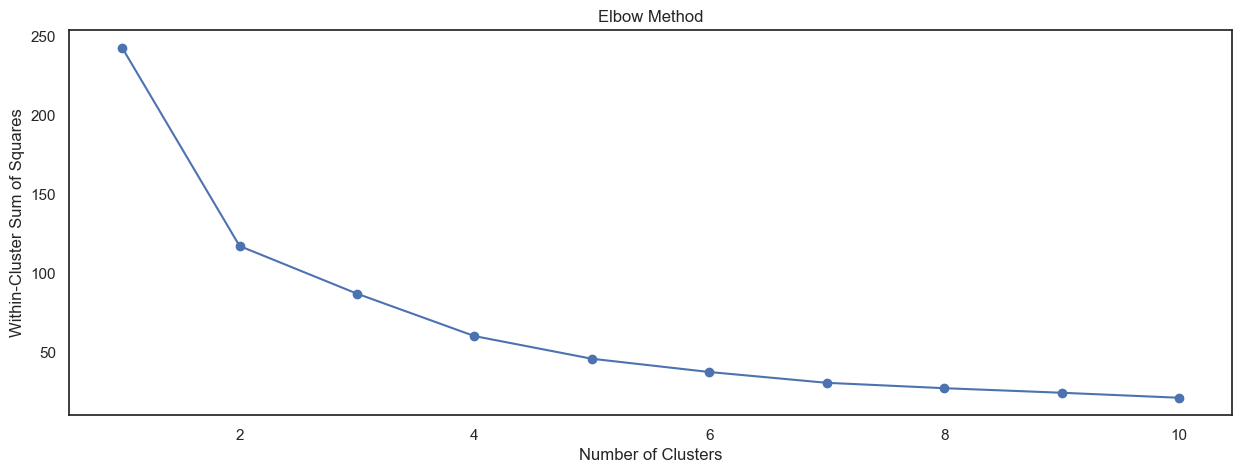

In [250]:
# Fit k-means model for a range of different values of k and calculate the WCSS for each value of K
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=7)
    kmeans.fit(last5_mean_wbc_std)
    wcss.append(kmeans.inertia_)
    
# Plot the WCSS for each value of k
plt.figure(figsize=(15,5))
plt.plot(range(1,11), wcss, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method')
plt.show()

In [251]:
kl = KneeLocator(range(1,11), wcss, curve='convex',direction='decreasing')

print(kl.elbow)

4


We will be using 4 clusters for our Analysis

In [252]:
# Perform k-means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state = 11)
kmeans.fit(last5_mean_w_std)

# assign data points to the clusters
clusters = kmeans.predict(last5_mean_w_std)

# Add cluster column to dataframe and assign each row a cluster
last5_mean_w['cluster'] = clusters + 1

print(last5_mean_w[last5_mean_w['region'] == 'Saint Petersburg'].head())

              region  avg_wine  cluster
58  Saint Petersburg      7.64        2


St. Petersburg belongs to cluster 2. Lets see what other regions are in that cluster.

In [253]:
print(last5_mean_w[last5_mean_w['cluster'] == 2])

                    region  avg_wine  cluster
6           Bryansk Oblast      7.94        2
11          Ivanovo Oblast      8.42        2
14      Kaliningrad Oblast      7.92        2
15           Kaluga Oblast      8.14        2
16          Kamchatka Krai      6.84        2
21            Kirov Oblast      7.90        2
23         Kostroma Oblast      7.16        2
28        Leningrad Oblast      8.16        2
30          Magadan Oblast      7.66        2
31        Mari El Republic      8.38        2
32                  Moscow      8.22        2
33           Moscow Oblast      7.82        2
36  Nizhny Novgorod Oblast      6.84        2
58        Saint Petersburg      7.64        2
60         Sakhalin Oblast      7.94        2
63         Smolensk Oblast      8.02        2
65       Sverdlovsk Oblast      7.36        2
70             Tver Oblast      8.10        2
74         Vladimir Oblast      8.56        2


There are a total of 21 regions in cluster 4. This means that these 21 regions have similar wine, brandy and champagne consumption to Saint Petersburg.

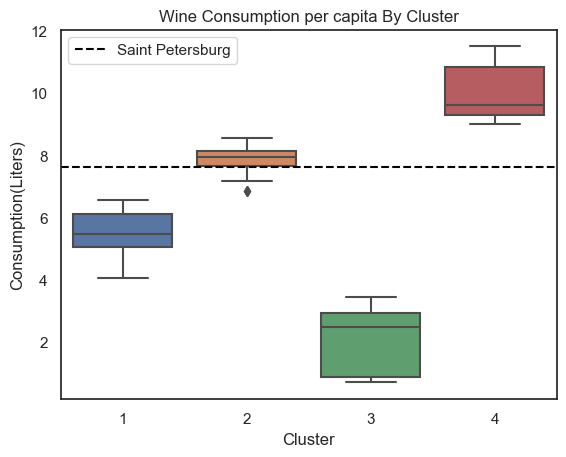

In [254]:
# Get data from St. Petersburg
%matplotlib inline
avg_wine = last5_mean_w.loc[last5_mean_w['region'] == 'Saint Petersburg', 'avg_wine'].item()

# Plot clusters
sns.boxplot(data=last5_mean_w, x='cluster', y='avg_wine')

plt.axhline(y=avg_wine, ls='--', color='black', label='Saint Petersburg')

# Labels for entire plot
plt.title('Wine Consumption per capita By Cluster')
plt.ylabel('Consumption(Liters)')
plt.xlabel('Cluster')
plt.legend()
plt.show()

##### Observations
- St. Petersburg fits nicely in cluster 2 for Wine consumption


For our prediction on the top 10 regions with consumption most similar to that of Saint Petersburg we are going to only use the wine and brandy values as these values were the best fit for St. Petersburg.

### 3.4 Regions to consider running promotion on
Now that we are satisfied with our clustering analysis we are going to predict the 10 best regions to run a wine promotion that will hopefully have similar success to the one done in St. Petersburg. To accomplish this we are going to use a method called Euclidean Distance.

Euclidean distance is a measure of the distance between two points in a multi-dimensional space. It is calculated as the square root of the sum of the squares of the differences between the coordinates of the two points. Euclidean distance is a common choice for measuring distance in data analysis and machine learning because it is simple to compute and is well-suited for continuous, numerical data.

In a clustering analysis, Euclidean distance can be used to find data points that are similar to one another within a cluster. When using Euclidean distance to compare data points, the data points with the smallest distance are considered to be the most similar. This can be useful for identifying patterns or trends within a cluster or for finding outliers that are significantly different from the other data points in the cluster.

#### Euclidean Distance Using Clustering Analysis

In [258]:
# Select the row for Saint Petersburg
st_petersburg = last5_mean_w[last5_mean_w['region'] == 'Saint Petersburg']

# Extract the consumption patterns for Saint Petersburg
st_petersburg_pattern = st_petersburg[['avg_wine']].values

# Extract the consumption patterns for all regions
region_patterns = last5_mean_w[['avg_wine']].values

# Calculate the Euclidean distance between the consumption patterns of each region and Saint Petersburg
distances = pairwise_distances(st_petersburg_pattern, region_patterns, metric='euclidean')

# Add the distances as a new column to the dataframe
last5_mean_w['distance'] = distances[0]

# Sort the dataframe by the distance column in ascending order
last5_mean_w = last5_mean_w.sort_values('distance')

promotion_candidates = last5_mean_w

# Select the top 10 regions with the lowest distance to Saint Petersburg

top_10 = last5_mean_w.head(11)

top_10 = top_10.iloc[1:12]

top_10 = top_10.reset_index()

In [256]:
# function that prints regions number from 1-10
def print_regions(df):
    for i, row in df.iterrows():
        print(f'{i+1}. {row["region"]}')

## 4. Final Recommendation

#### Ranking Potential Candidates
Here are all 19 potential candidates that we found had similar wine consumption per capita to St. Petersburg.

In [273]:
promotion_candidates = promotion_candidates[promotion_candidates['cluster'] == 2].iloc[1:]
promotion_candidates
promotion_candidates[['region', 'avg_wine']]

,region,avg_wine
14,Kaliningrad Oblast,7.92
60,Sakhalin Oblast,7.94
6,Bryansk Oblast,7.94
63,Smolensk Oblast,8.02
70,Tver Oblast,8.10
23,Kostroma Oblast,7.16
15,Kaluga Oblast,8.14
28,Leningrad Oblast,8.16
32,Moscow,8.22
31,Mari El Republic,8.38


##### Top 10 Candidates
We used the Euclidean Distance of our clustering analysis to find the top 10 regions with the most similar wine consumption to St. Petersburg and recommend the following regions ranked from most to least similar:

In [276]:
print_regions(top_10)

1. Magadan Oblast
2. Moscow Oblast
3. Kirov Oblast
4. Sverdlovsk Oblast
5. Kaliningrad Oblast
6. Sakhalin Oblast
7. Bryansk Oblast
8. Smolensk Oblast
9. Tver Oblast
10. Kostroma Oblast


##### Limitations of Prediction
Note that the most important limitation of our analysis was that the data given used per capita consumption - so population of regions was not considered in this analysis. The promotion should perform similarly to the one in St. Petersburg, but it is possible that regions selected could have low populations so total sales numbers could be lower in these regions than others.